In [6]:
from astropy.io import fits
from IPython.display import Image

%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


This example notebook demonstrates how `pyTWR` radial modification of Tremaine-Weinderg method, introduced in https://arxiv.org/pdf/astro-ph/0511069.pdf, should be applied to real data.

In [7]:
import pytwr

# Data preparation

We will use the same CO data for **NGC 4414** from BIMA SONG survey https://ned.ipac.caltech.edu/level5/March02/SONG/SONG.html, as in the original paper.

We need FITS files for TWR: velocities map (moment 1) and surface densities (or intensities as equivalent, moment 0).

For correct estimation we also need to find in literature of measure information about positional angle (`PA`), distance to galaxy (`D`), size of pix in data in arcsec (`bima_scale`), galaxy center location on image and systemic velocity if moment 1 map not corrected for it. Additionally we also need to know inclination (`incl`) of the galaxy under consideration.

In [8]:
D = 19.1 # Mpc, thus dist_scale = 0.092599413091921 kpc/arcsec

bima_scale = 1. # arcsec/pix

pix_kpc = bima_scale*0.092599413091921 # kpc/pix

PA = 160. # deg

image_center = (128.5, 128.5) # image center in pix

incl = 60. # deg

v_syst = 726. # km/s, see Table 1 in arxiv.org/pdf/astro-ph/0304294.pdf

Load data and take a look at it:

In [9]:
fname = './NGC4414.bima12m.gmom1.fits'
mom1data = fits.getdata(fname)
mom1data[np.isnan(mom1data)] = 0.

fname = './NGC4414.bima12m.mmom0.fits'
mom0data = fits.getdata(fname)
mom0data[np.isnan(mom0data)] = 0.000000001
mom0data[mom0data < 0.] = 0.000000001

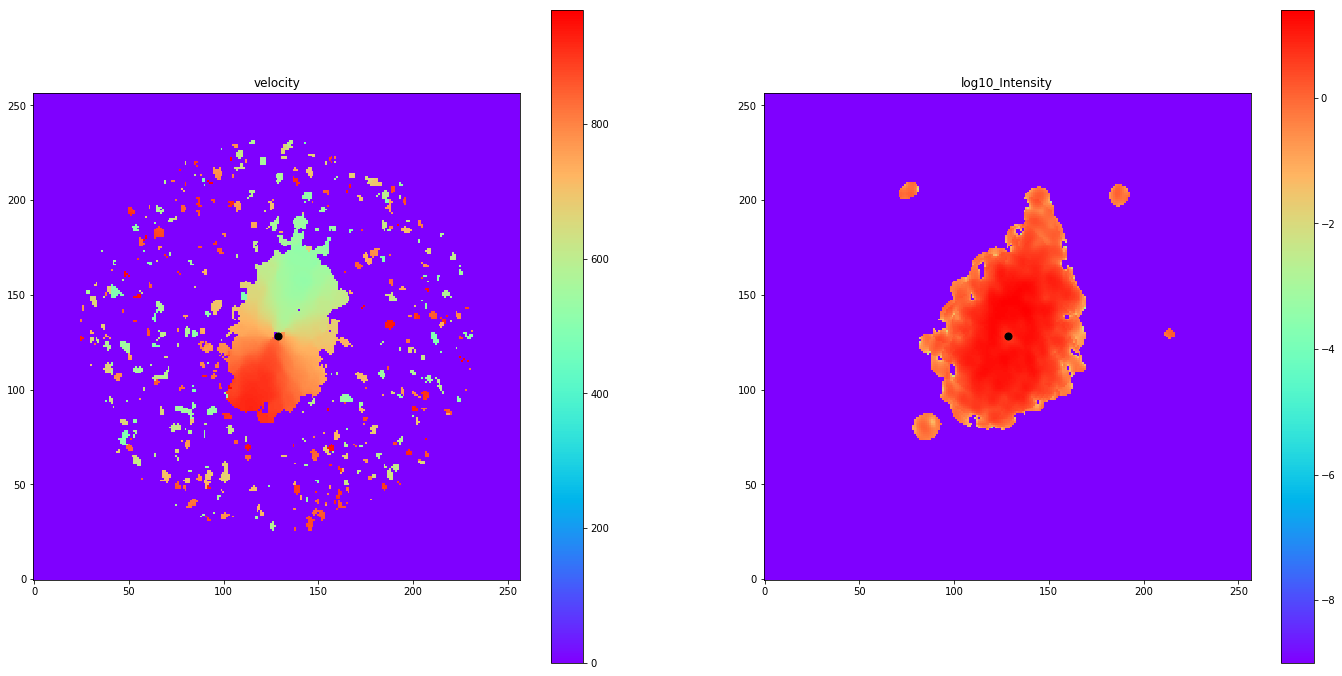

(1, 1, 257, 257)

In [10]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(mom1data), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(mom0data)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()
shape(mom0data)

Let's rotate both maps thus so major axis align parallel to X-axis. *Note that you sometimes you need to use 90+PA instead of PA, just keep an eye on resulted image.*

In [11]:
plane_v = np.zeros((257, 257))
plane_intens = np.zeros((257, 257))
plane_v = pytwr.rotate_image(mom1data[0,0,:,:], angle=160.+90., center=image_center)
plane_intens = pytwr.rotate_image(mom0data[0,0,:,:], angle=160.+90, center=image_center)

Subtract systemic velocity:

In [12]:
plane_v = plane_v - v_syst
plane_v[plane_v < -v_syst+0.001] = 0. # to keep all pixs with zero signal

/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


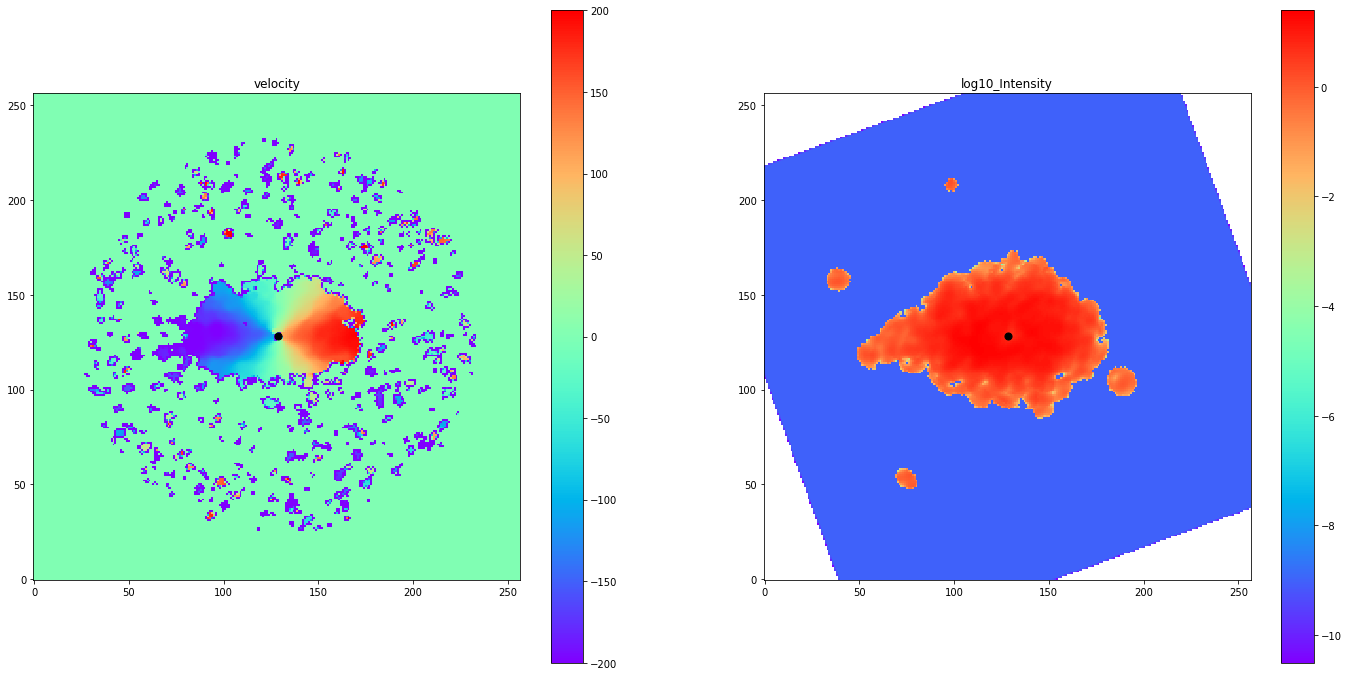

In [13]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(plane_v), origin='lower', cmap='rainbow', vmin=-200, vmax=200)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(plane_intens)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()

Make sure that velocities on Y-axis are close to zero, which mean the PA rotation and systemic velocity are correct.

Data is ready now for pattern velocity search.

# Application of TWR

To find pattern speeds we need to select side of the galaxy we will use (y>0 or y<0) and solve Eq. (3) from https://arxiv.org/pdf/0711.4104.pdf numerically. To do so, we need to cut galaxy to ellipses (see Fig. 1 in the same page), choose limits of integration `X_lim` and solve triangular matrix equation.

How we cut to ellipses is an essential part, because this determines on which radii we will detect pattern speed $\Omega$ (and its variations). Usually it is natural to have cuts of the same width, so we need to choose `ymin` - offset from the galaxy's center in pix (or, in other words, where we start the first ellipse. This is needed if you want to avoid bar, etc.), `delta_y` - step between cuts and number of cuts `y_bins`. 

Let's illustrate this for y>0 side:

/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log10


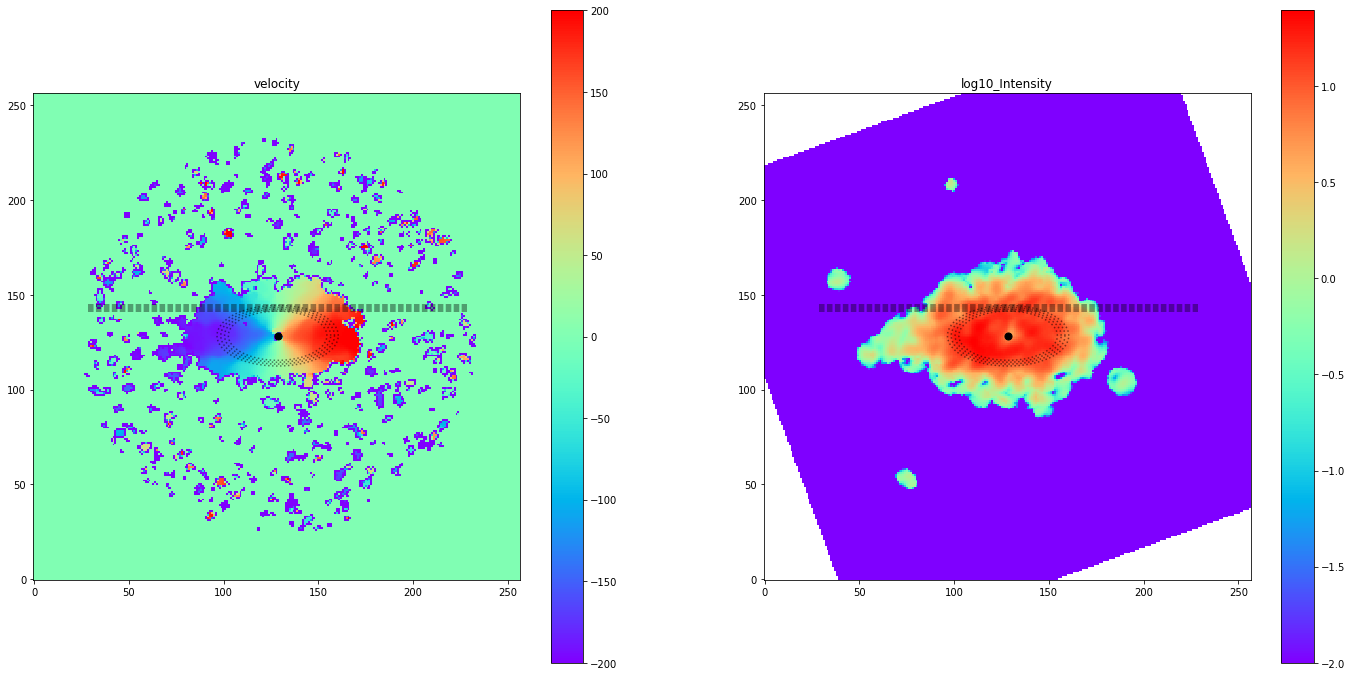

In [17]:
ymin = 8.
y_bins = 3
delta_y = 5.
X_max = 100.
exitFlag=False
for y_bins in range (3,15):
    #exitFlag=False
    #omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
      #              center=image_center, incl=incl,
       #             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
        #            verbose=False, 
         #           r_scale=pix_kpc, 
          #          lim_frame=True)
   # aa = np.array(omega.shape)
   # aa[:] = 0
   # bb = np.array(omega.shape)
   # bb[:] = 600
   # check = np.logical_and(omega>0.,omega<1000.)
   # if(np.all(check)):
   #     break   
    for delta_y in range (1,8):
        #exitFlag=False
        #omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
        #                center=image_center, incl=incl,
        #                delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
        #                verbose=False, 
        #                r_scale=pix_kpc, 
        #                lim_frame=True)
       # check = np.logical_and(omega>0.,omega<1000.)
       # if(np.all(check)):
       #     exitFlag=True
       #     break
                
        for ymin in range (0,17):
         #   exitFlag=False   
            omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                            center=image_center, incl=incl,
                            delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                            verbose=False, 
                            r_scale=pix_kpc, 
                            lim_frame=True)       
            check = np.logical_and(omega>0.,omega<1000.)
            if(np.all(check)):
                exitFlag=True
                break
                     
            #ymin +=1
        if(exitFlag):
            break    
       # delta_y +=1
    if(exitFlag):
        break 
   # y_bins +=1   
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(plane_v), origin='lower', cmap='rainbow', vmin=-200, vmax=200)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

pytwr.overlay_ellipses_grid(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=image_center, incl=incl)

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(plane_intens)), origin='lower', cmap='rainbow', vmin=-2)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

pytwr.overlay_ellipses_grid(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=image_center, incl=incl)

plt.show()

There are 3 radial bins, because the inner one is just offset and not included. Let's show how TWR can be applied for exactly the same set of parameters:

In [186]:
%%time
#omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                             center=image_center, incl=incl,
                             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                             verbose=False, 
                             r_scale=pix_kpc, 
                             lim_frame=True)

CPU times: user 1min 30s, sys: 12.1 s, total: 1min 42s
Wall time: 1min 17s


Besides already known parameters there are three additional:

* `verbose` constrols if you want to see additional prints and pictures for better understanding and debugging (example below)
* `r_scale` is just a scale in kpc/pix to convert $\Omega$ to proper units
* `lim_frame` works for `verbose=True` only and regulate if we see the full image or just part of it

Returned values are list of pattern speeds in km/s/kpc and radial bins in pix:

In [13]:
omega, rrs

(array([ 1.41513225e+04, -1.91461158e+05, -4.98672993e+04,  2.54181707e+03,
         6.34699084e+01]),
 [19.532393420183297,
  28.077815541513488,
  36.62323766284368,
  45.168659784173876,
  53.71408190550407,
  62.25950402683426])

Let's plot them:

13 3 1 100.0


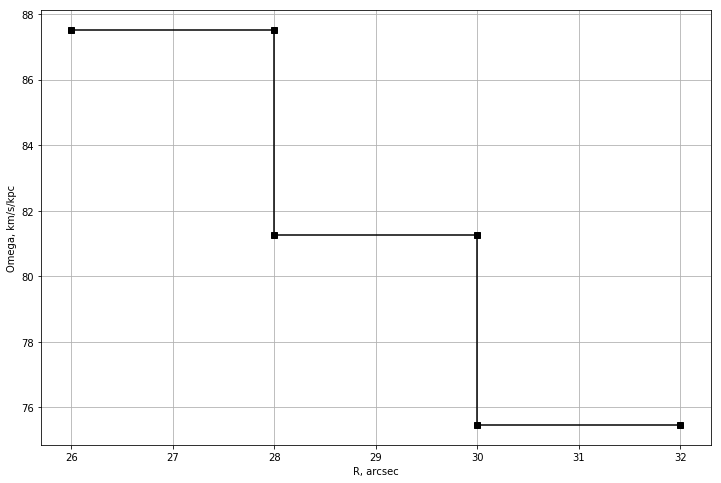

In [18]:
print(ymin,
y_bins,delta_y,
X_max)
fig = plt.figure(figsize=[12,8])
ax = plt.gca()
tmp = []
for ind, om in enumerate(omega):
    tmp.append([rrs[ind]*bima_scale, om])
    tmp.append([rrs[ind+1]*bima_scale, om])
tmp = np.array(tmp)
ax.plot(tmp[:, 0], tmp[:, 1], '-s', color='k')
ax.grid()
plt.xlabel('R, arcsec')
plt.ylabel('Omega, km/s/kpc')
plt.show()

Thus we can conclude that for such parameters $\Omega$ is not constant and vary in the disk.

Let's run the same TWR with `verbose=True` to get many additional plots:

/home/guzel/LALA/QQQ/new/pyTWR-master/pytwr.py:182: RuntimeWarning: divide by zero encountered in log2
  plot_ifverbose_map(ax, np.log2(intens), 'log2_Intensity', lim_frame, ymin, delta_y, y_bins, X_max, cen_x, cen_y, cmap='rainbow')


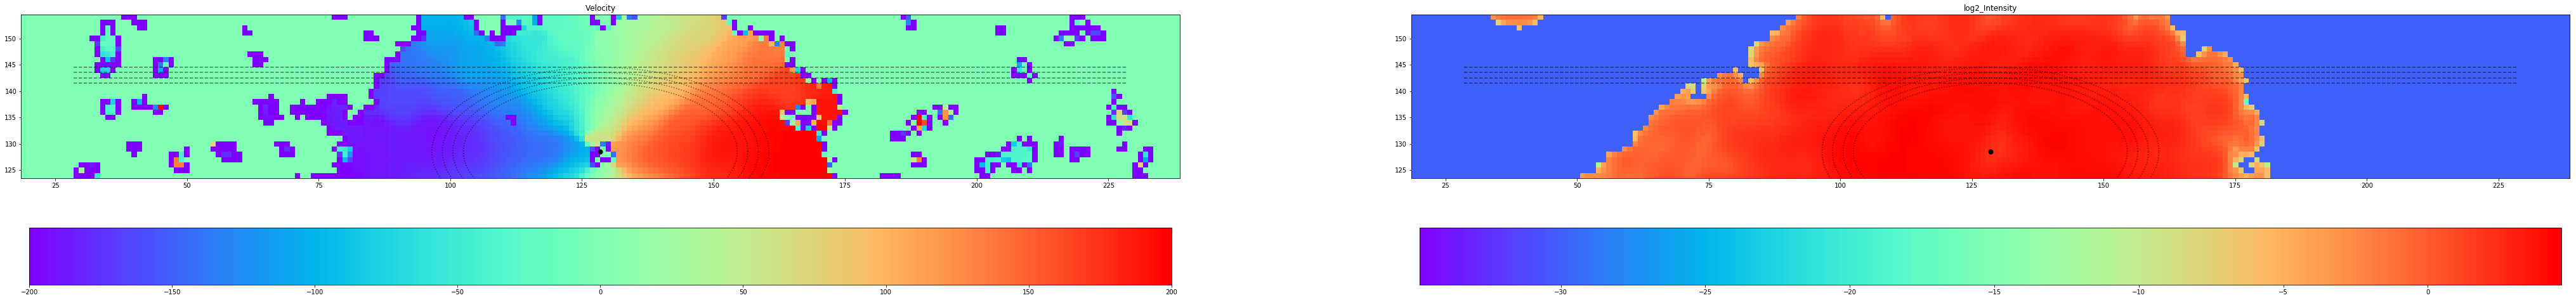

Radial bins: {rrs}



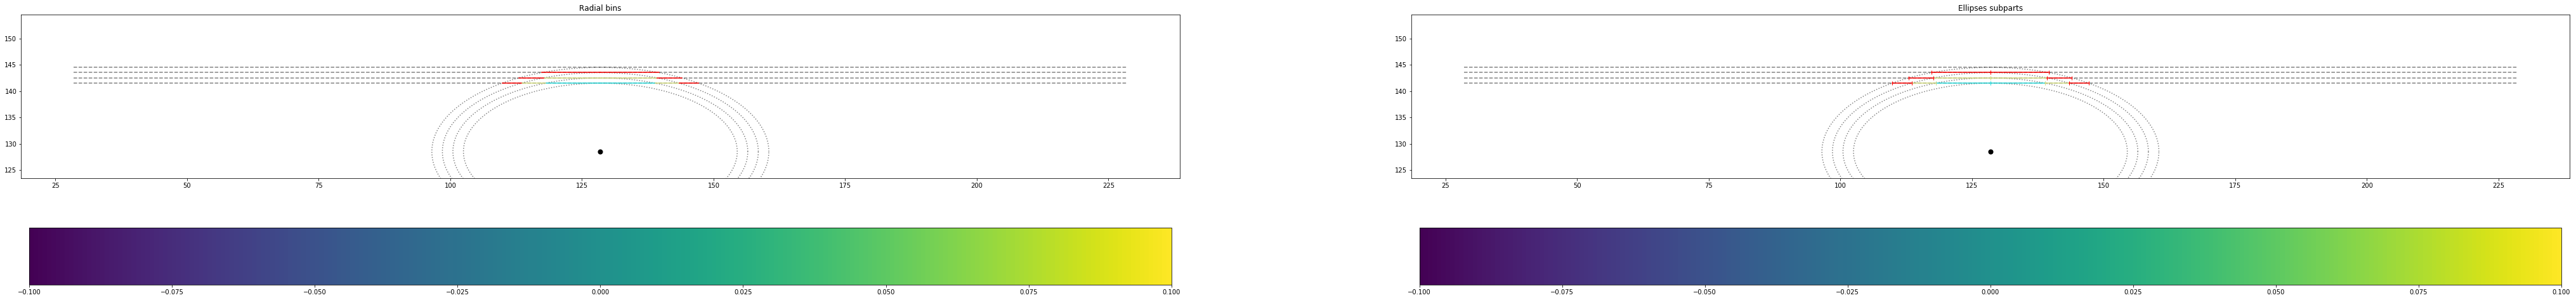

K:
  [[ 10.95956122  10.46130459 -14.79072609]
 [  0.          18.71801582  11.64045757]
 [  0.           0.          28.48461263]]
b:
  [ 693.11071681 2399.35560824 2149.56167187]
Omega: [87.5263843  81.25436993 75.46396012]
Residuals: [0. 0. 0.]


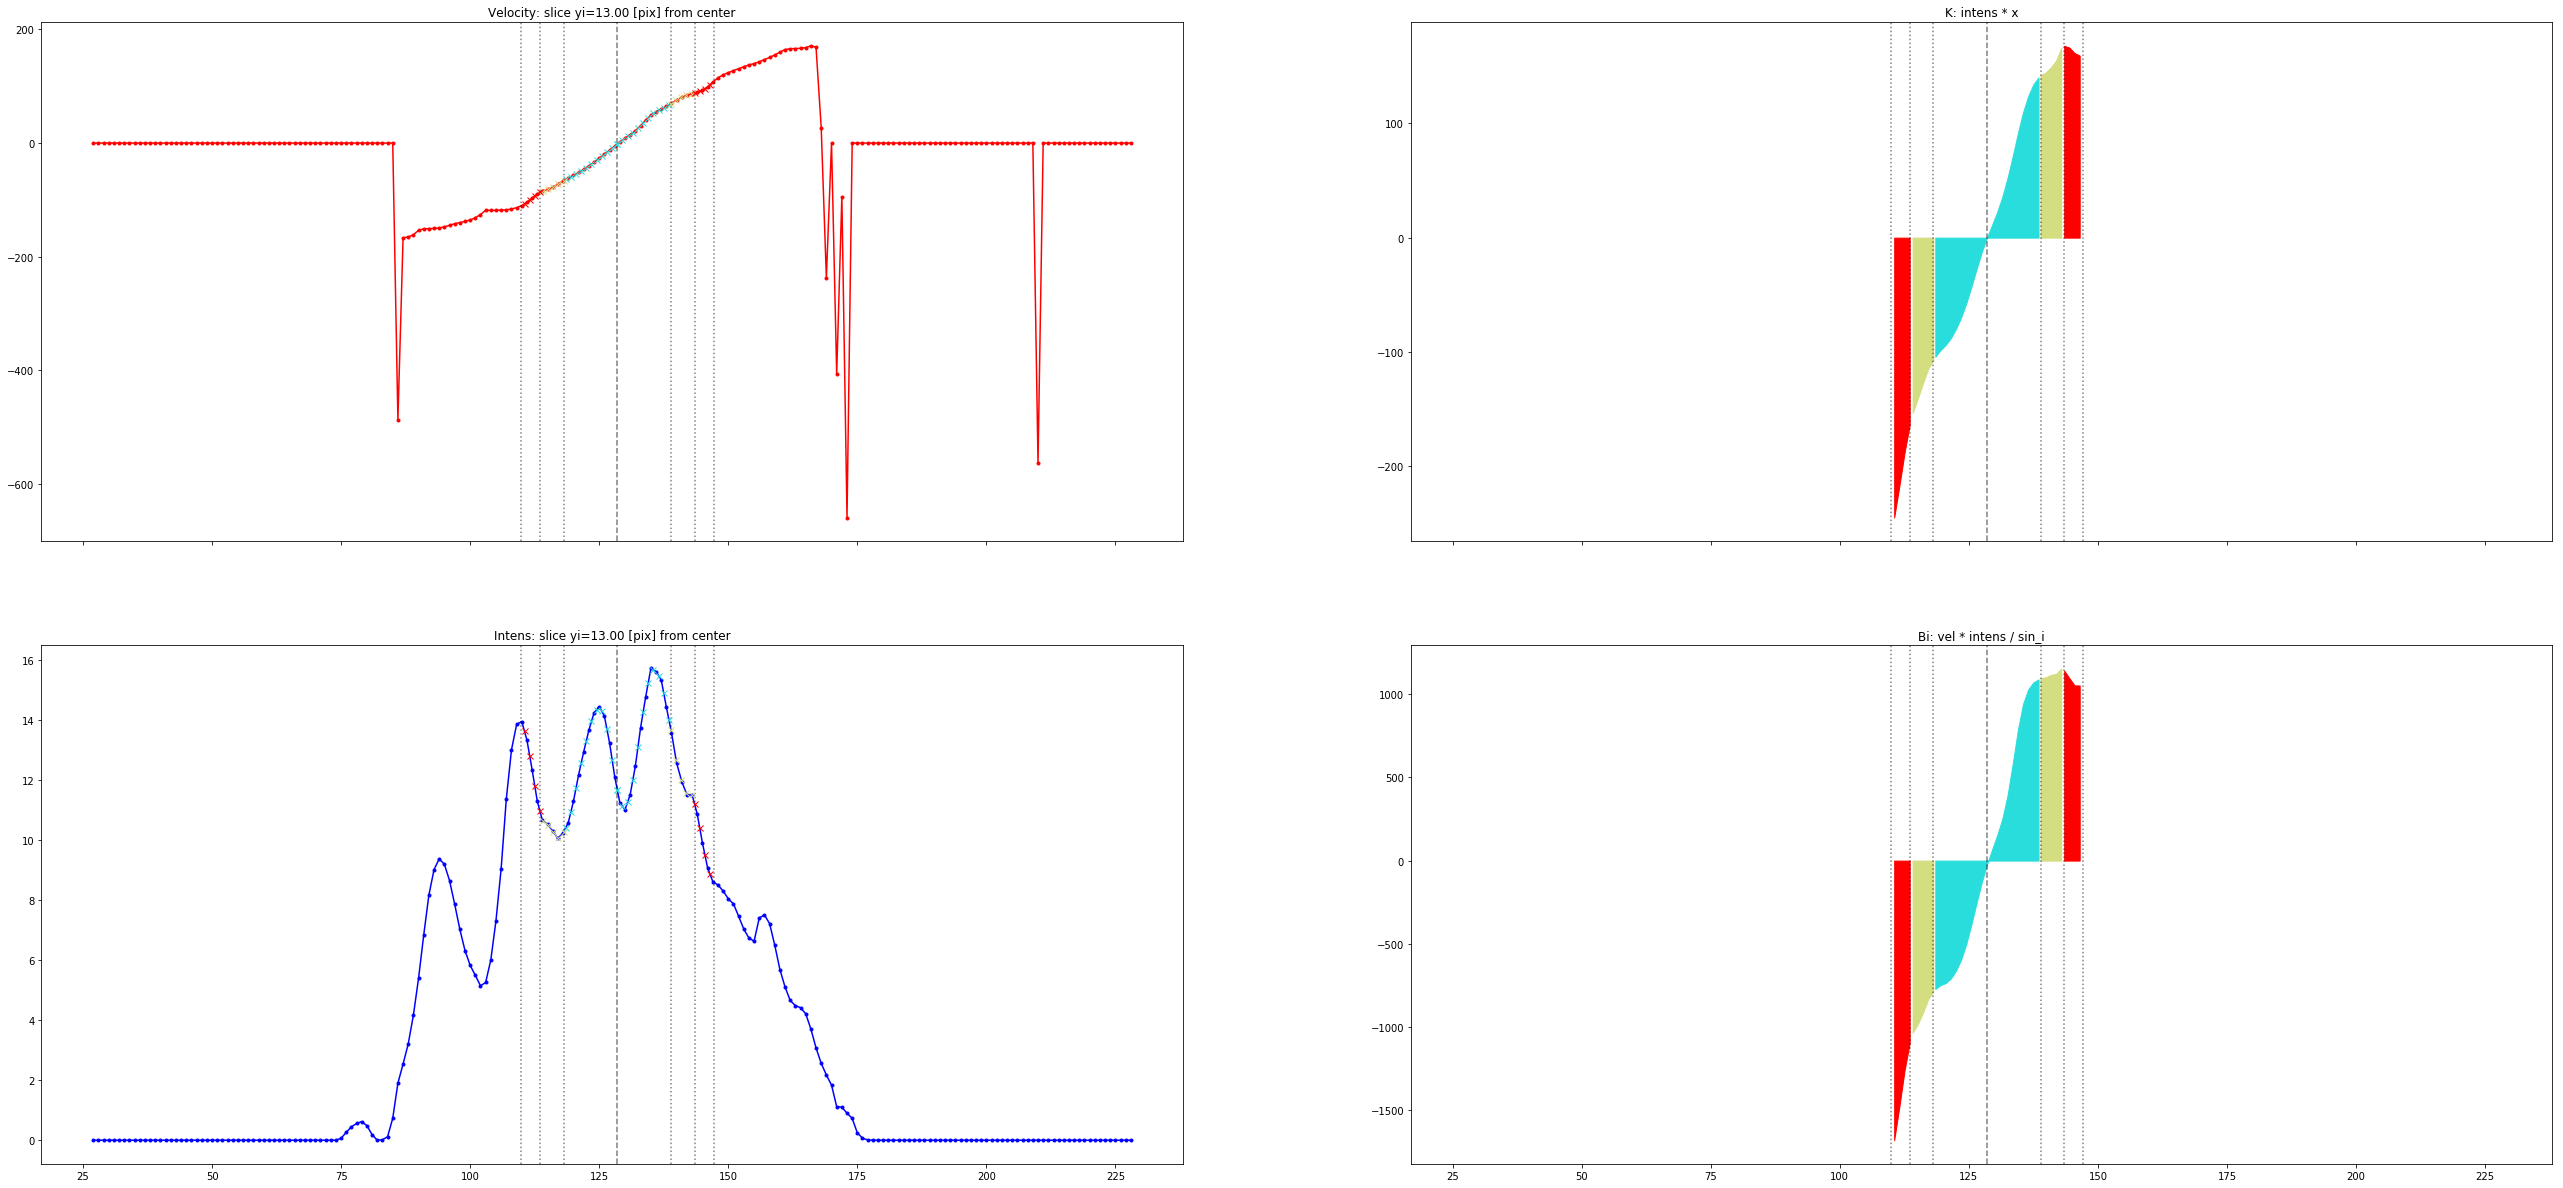

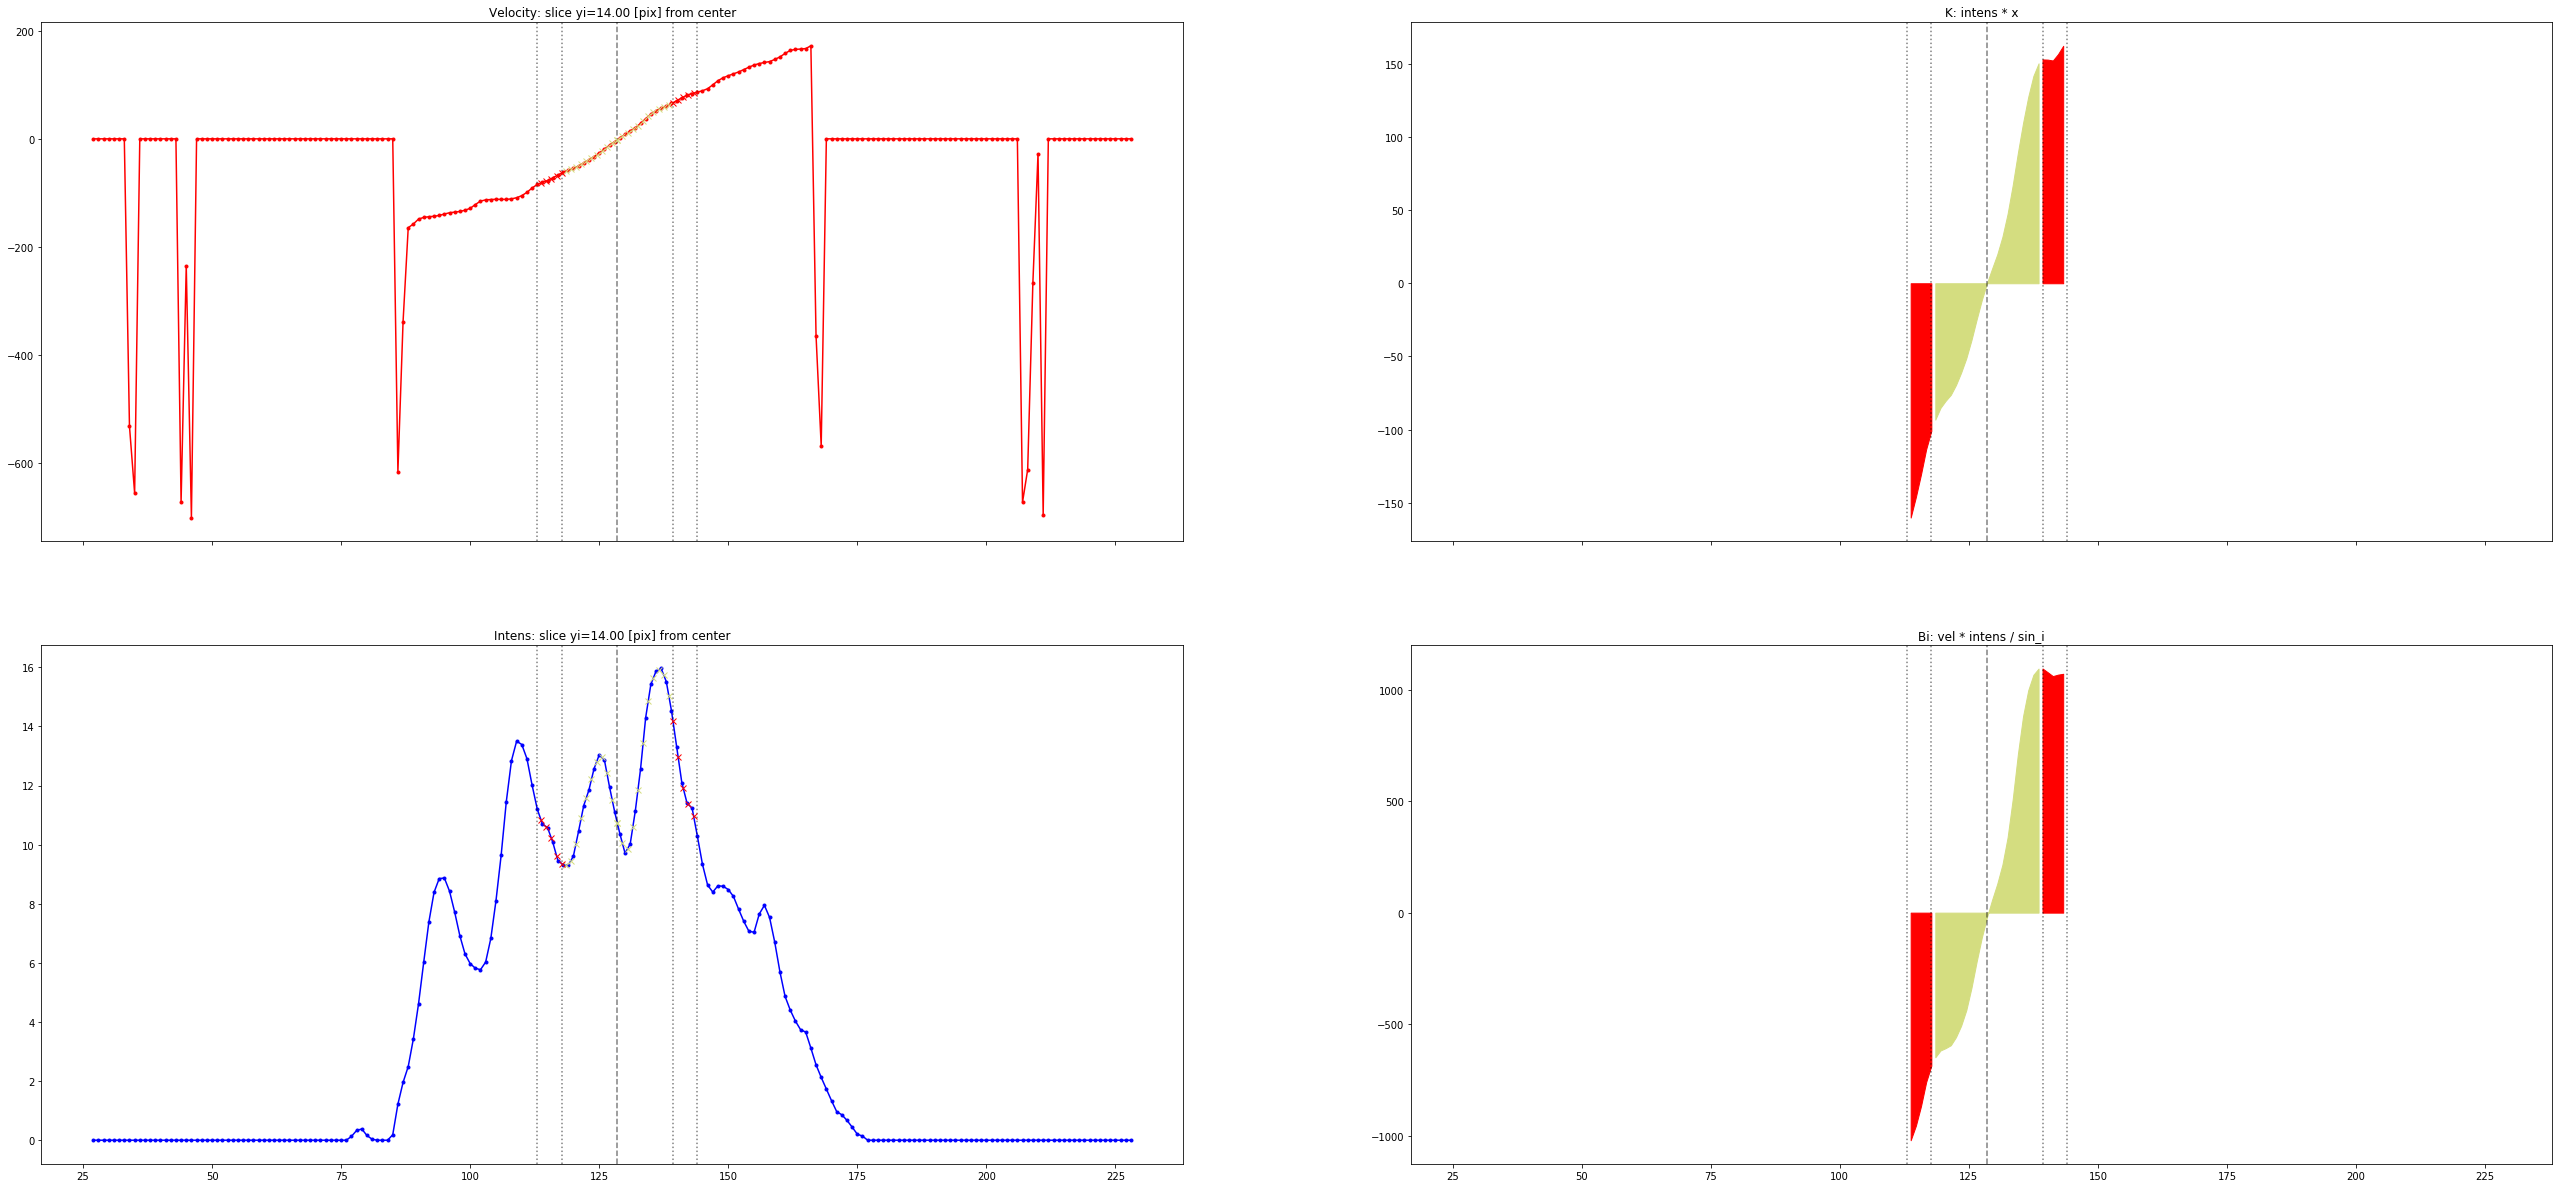

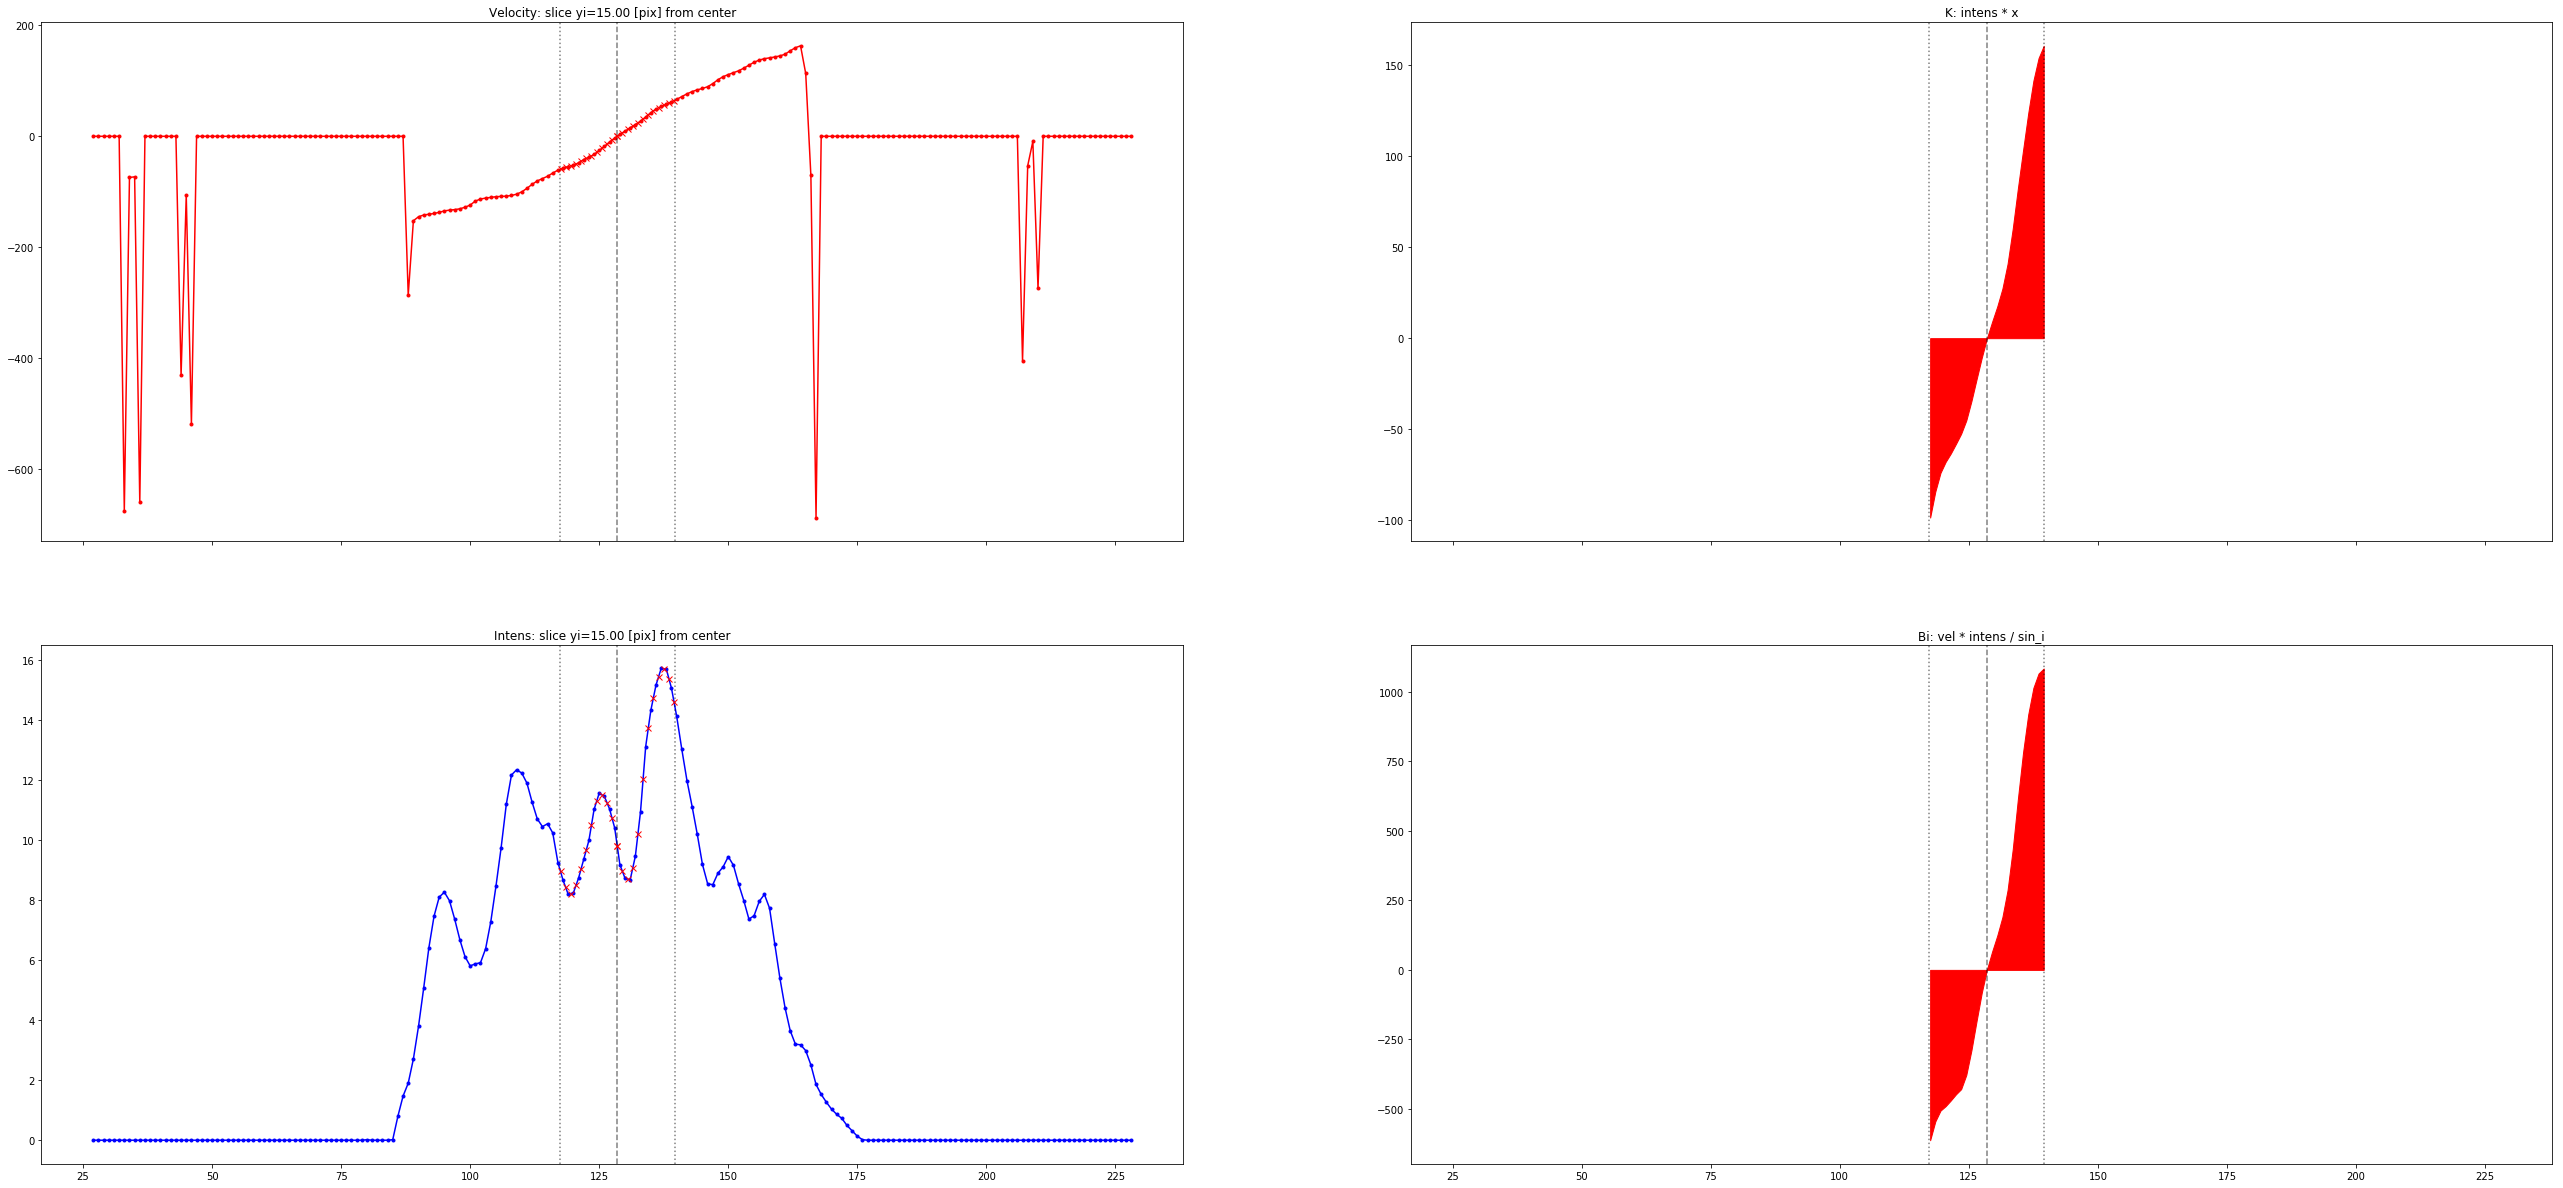

In [19]:
omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                             center=image_center, incl=incl,
                             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                             verbose=True, 
                             r_scale=pix_kpc, 
                             lim_frame=True)

We now see additional information, including matrix, right side of the equation, residuals of solution and many additional plots, which shows location of ellipses and integration limits on data maps, all slices on them and which part each segment adds in equation left and right side (all color-coded).

# Original TW method

We can also apply original T-W method for constant $\Omega$. Notation and logic are the same, but we can also explicitly state slice positions.

In [20]:
%%time
pytwr.solve_TW(intens=plane_intens,
              vel=plane_v,
              center=image_center,
              incl=incl,
              ys = [],
              delta_y=6.,
              y_bins=7,
              X_max=100.0,
              ymin=0.,
              verbose=False,
              r_scale=pix_kpc,
              ax=None,
              img_scale=1.5)

CPU times: user 47.9 s, sys: 10.4 s, total: 58.2 s
Wall time: 38.7 s


(-81.02455699918629, 35.476413285301874)

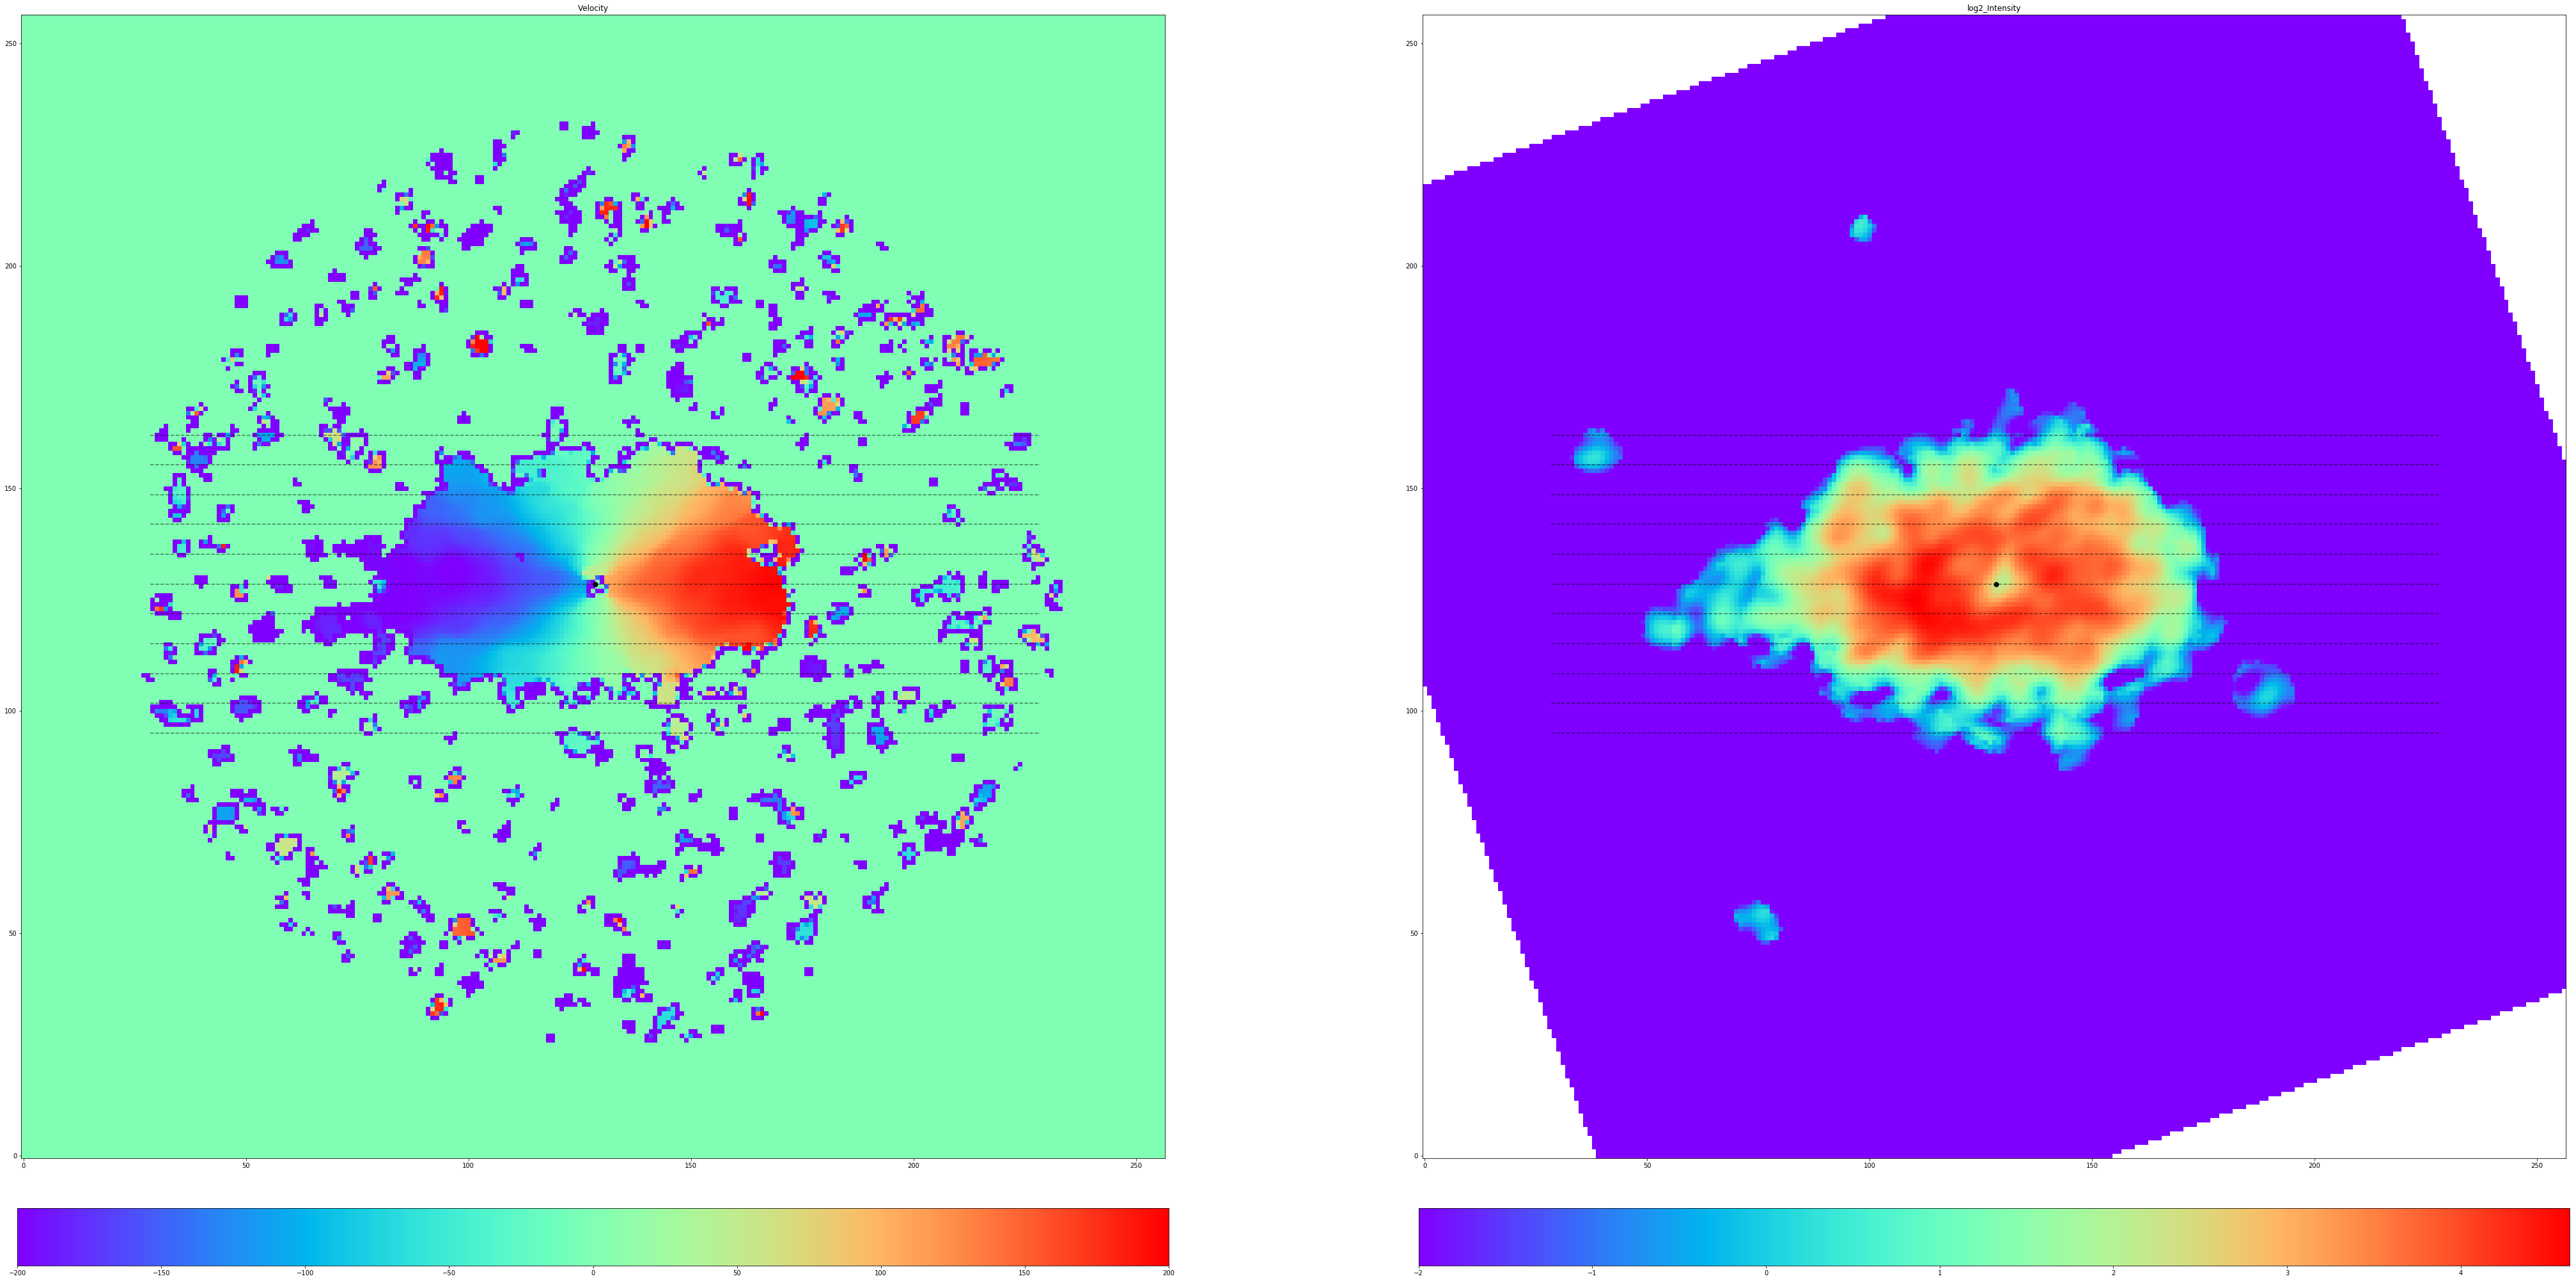

coefficient of determination R^2: 0.3278309832914257
intercept: -59.894+/-11.410 (SE)
slope Ω: -60.517+/-28.885 (SE)


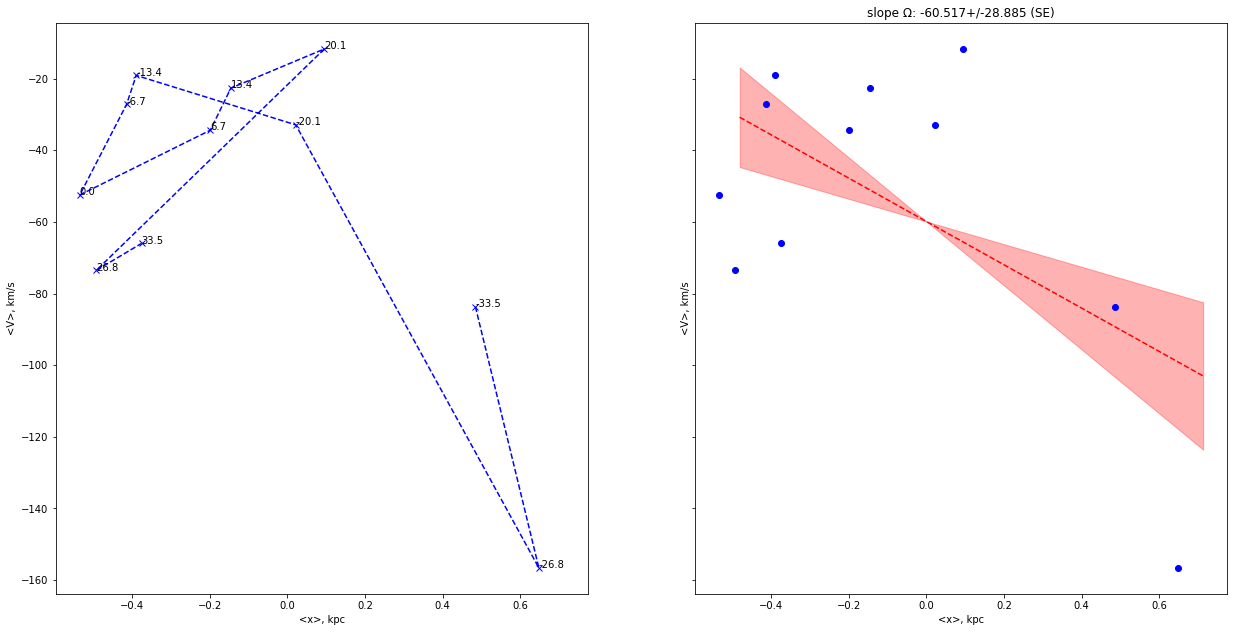

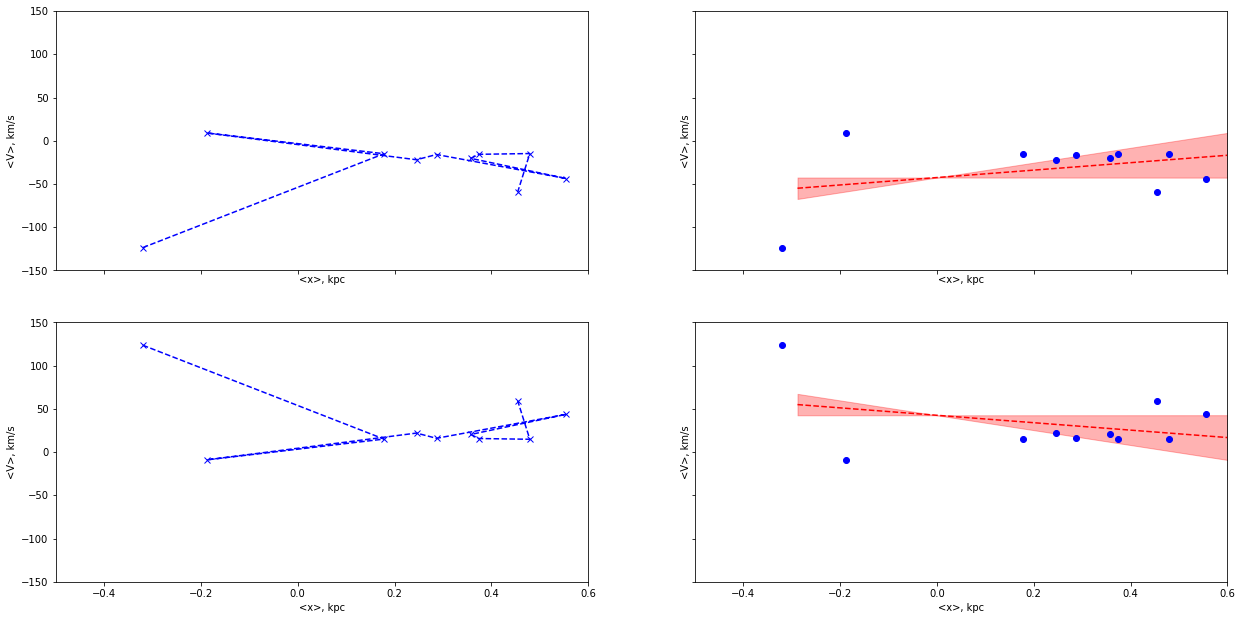

slope Ω: -42.936+/-43.098 (SE)


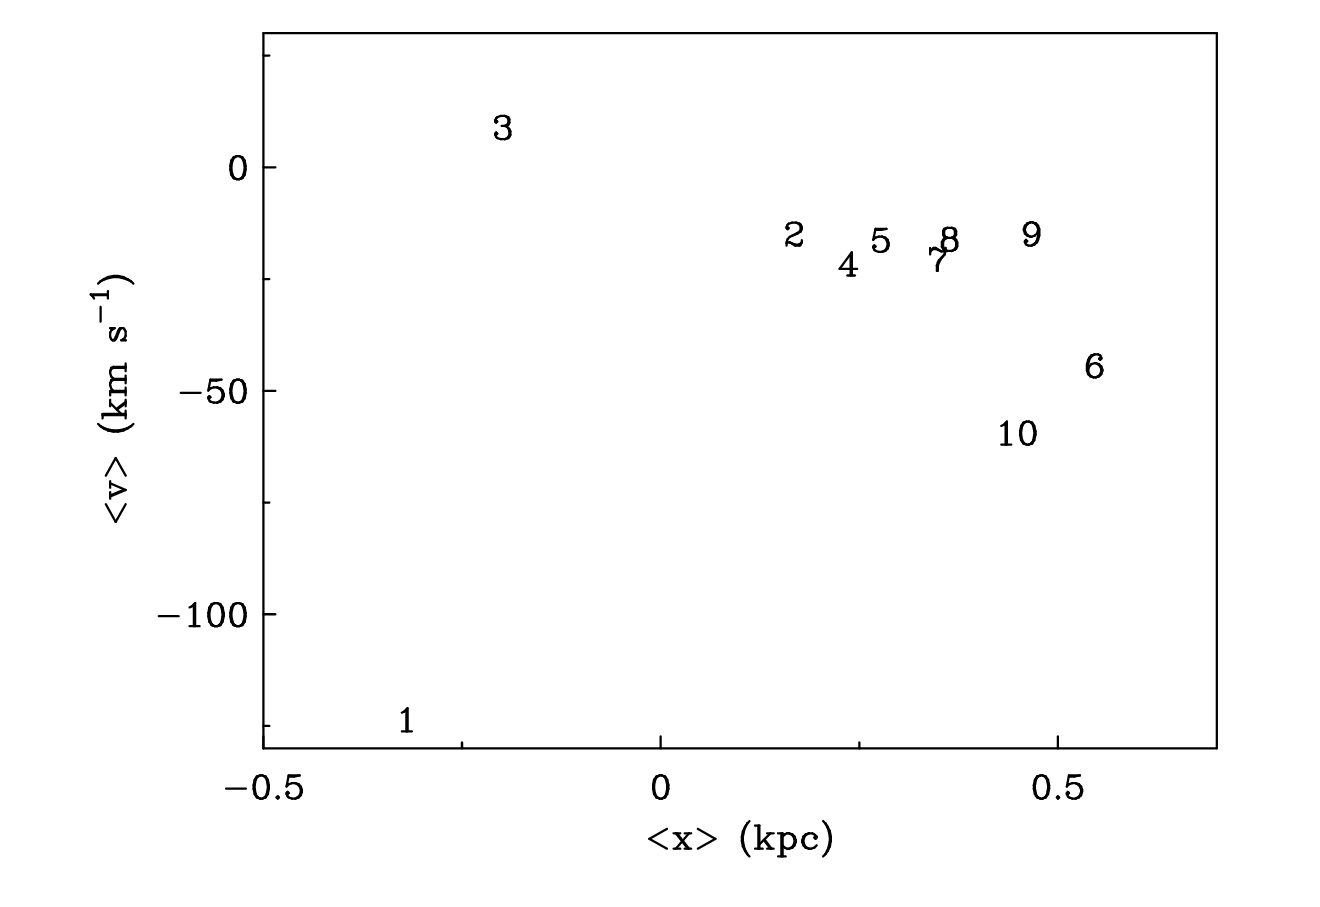

In [16]:
omega, omega_SE = pytwr.solve_TW(intens=plane_intens,
              vel=plane_v,
              center=image_center,
              incl=incl,
              ys = [],
              delta_y=6.7,
              y_bins=5,
              X_max=100.0,
              ymin=0.,
              verbose=True,
              r_scale=pix_kpc,
              ax=None,
              img_scale=1.5)

import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

NGC4414=np.array([-0.3197583966321955, -123.54260089686096,
0.17834263750343204, -15.022421524663685,
-0.1871682529514047, 8.968609865470842,
0.24541273908666617, -21.97309417040359,
0.28669236752997185, -15.919282511210767,
0.5549727738629086, -43.721973094170394,
0.3577777523565481, -20.403587443946186,
0.3734442207376224, -15.695067264573993,
0.4793802049967971, -14.79820627802691,
0.4542818248375585, -59.41704035874439])

def linm(slope, intercept, xvals):
    return slope * xvals + intercept

xp=NGC4414[0::2]
yp=NGC4414[1::2]
img_scale=1.5
ys = []
x = sm.add_constant(xp.reshape((-1, 1)))
ols = sm.OLS(yp, x)
ols_result = ols.fit()
r_sq = ols_result.rsquared
    
fig, axes = plt.subplots(figsize=[14 * img_scale, 7 * img_scale], ncols=2, nrows=2, sharey=True, sharex=True)

ax = axes[0][0]
ax.plot(xp, yp, 'x--', color='b')
for ind_i, yi in enumerate(ys):
    ax.annotate(str(yi), (xp[ind_i], yp[ind_i]))

ax.set_xlabel('<x>, kpc')
ax.set_ylabel('<V>, km/s')

ax = axes[0][1]
ax.plot(xp, yp, 'o', color='b')
pps = np.linspace(min(xp)*0.9, max(xp)*1.1, 100)
y_pred = linm(ols_result.params[1], ols_result.params[0], pps)
ax.plot(pps, y_pred, '--', color='r')
y_pred_max = linm(ols_result.params[1] - ols_result.bse[1], ols_result.params[0], pps)
y_pred_min = linm(ols_result.params[1] + ols_result.bse[1], ols_result.params[0], pps)
ax.fill_between(pps, y_pred_max, y_pred_min, alpha=0.3, color='r')
ax.set_xlabel('<x>, kpc')
ax.set_ylabel('<V>, km/s')

ax = axes[1][0]
ax.plot(xp, -yp, 'x--', color='b')
for ind_i, yi in enumerate(ys):
    ax.annotate(str(yi), (xp[ind_i], yp[ind_i]))
ax.set_xlabel('<x>, kpc')
ax.set_ylabel('<V>, km/s')

ax = axes[1][1]
ax.plot(xp, -yp, 'o', color='b')
pps = np.linspace(min(xp)*0.9, max(xp)*1.1, 100)
#y_pred = linm(ols_result.params[1], ols_result.params[0], pps)
ax.plot(pps, -y_pred, '--', color='r')
#y_pred_max = linm(ols_result.params[1] - ols_result.bse[1], ols_result.params[0], pps)
#y_pred_min = linm(ols_result.params[1] + ols_result.bse[1], ols_result.params[0], pps)
ax.fill_between(pps, -y_pred_max, -y_pred_min, alpha=0.3, color='r')
ax.set_xlabel('<x>, kpc')
ax.set_ylabel('<V>, km/s')
ax.set_xlim(-0.5,0.6)
ax.set_ylim(-150,150)
plt.show()
print('slope Ω: {:.3f}+/-{:.3f} (SE)'.format(-ols_result.params[1], ols_result.bse[1]))
from IPython.display import Image
Image('4414.png')

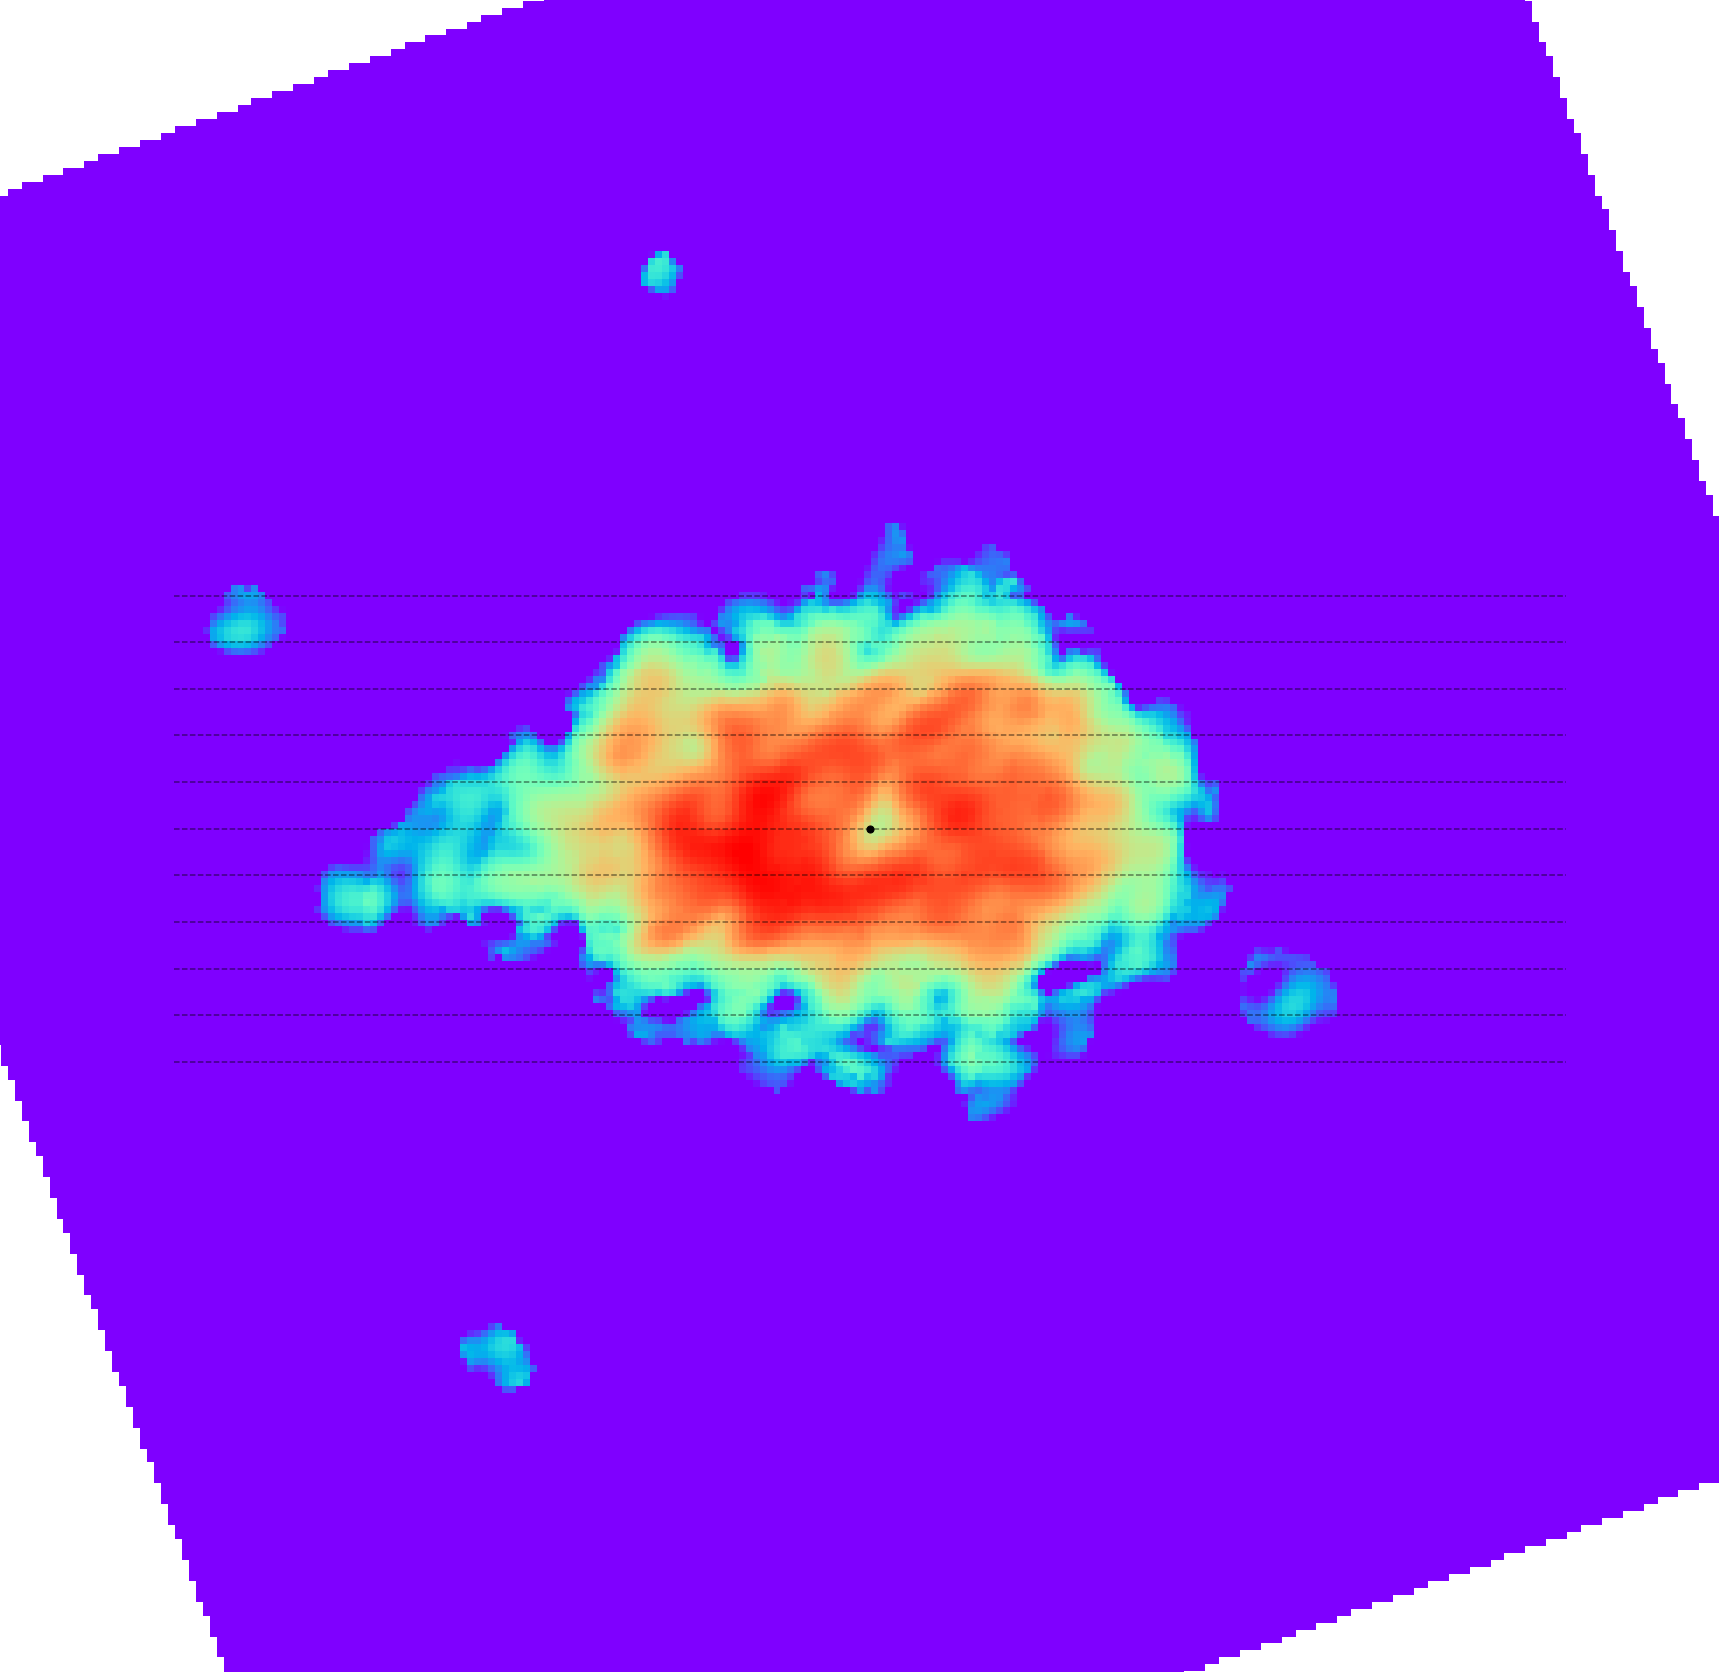

In [19]:
Image('4414a.png')

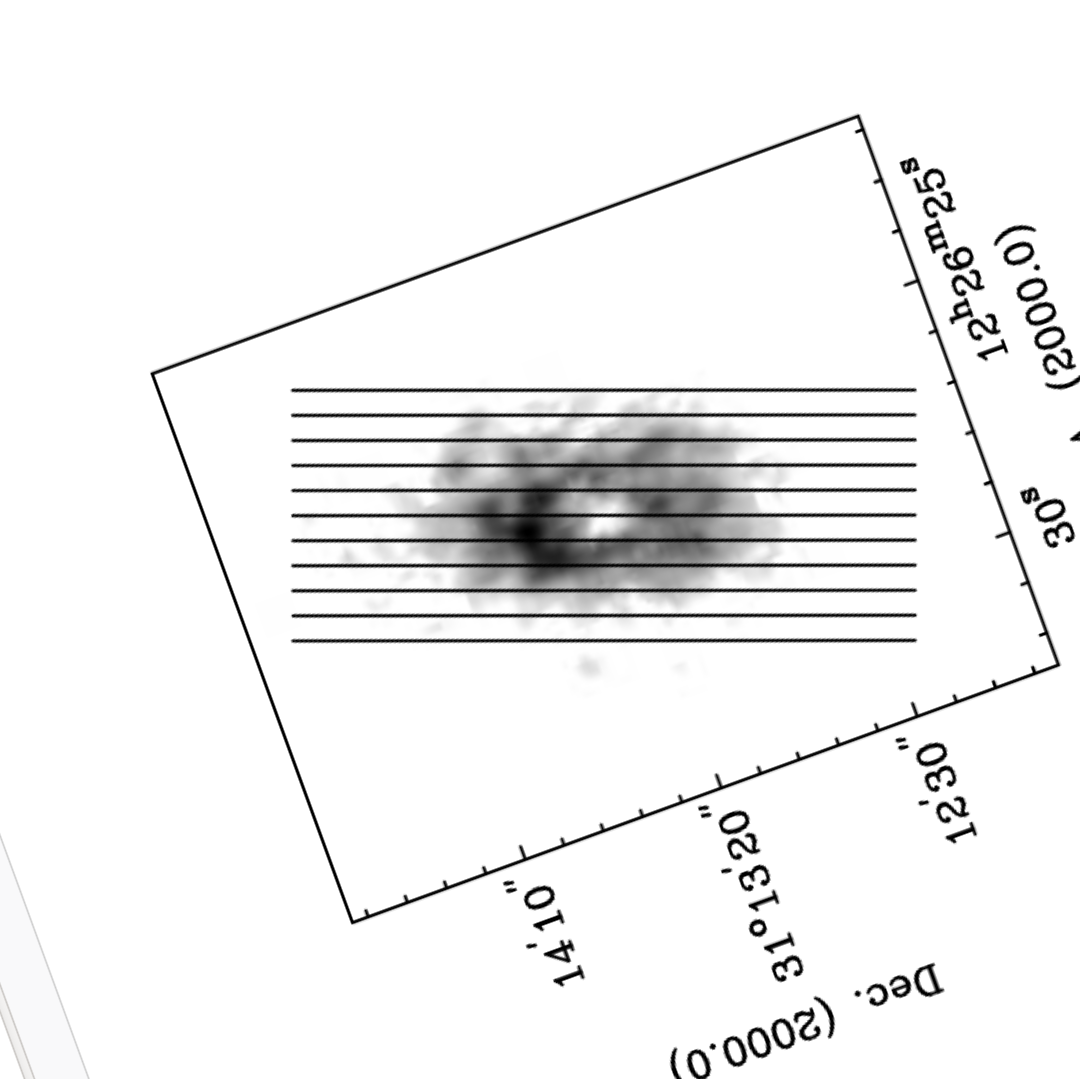

In [18]:
Image('4414b.png')